In [1]:
# Operations' Libraries
import scipy.io
import numpy as np
# Neural Network Library
from time import time
import tensorflow as tf
# Plotting Libraries
import matplotlib.pyplot as plt
from matplotlib import interactive
from mpl_toolkits.mplot3d import Axes3D

In [2]:
dt='float32'  # Defining variable for data type of the tensors
# Storing constants used in equations
pi = tf.constant(np.pi, dtype = dt)
nu = 0.01/pi

## 1-D Burgers' Equation

## ∂u/∂t + u∂u/∂x − (0.01/π)∂$^{2}$u/∂x$^{2}$ = 0 
### u(0,x) = −sin(πx) .... IC
### u(t,−1) = u(t,1)=0 .... BCs

### Domain --> x∈[−1,1], t∈[0,1]

In [3]:
######## LOSS FUNCTIONS ########

# IC ---> x =[-1,1] & t = 0  
def loss_u_0(x):
    return -tf.sin(pi*x)

# BC ---> x = -1 & t = [0,1]
# BC ---> x = 1 & t = [0,1]
def loss_u_b(t,x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=dt)

# u_hat_t + u_hat*u_hat_x + nu_u_hat_xx = 0 
def loss_PDE(t,x,u,u_t,u_x,u_xx):
    return u_t + u * u_x - nu * u_xx

## Pre-Processing

In [4]:
# Set number of data points
N_0 = 50  # For IC
N_b = 50  # For BC
N_i = 10000 # For internal points

# Set boundary points
tmin, tmax = 0.0, 1.0
xmin, xmax = -1.0, 1.0

# Converting float constants into tensor for faster computation

# Lower bound of data
lb = tf.constant([tmin, xmin], dtype=dt)
# Upper bound of data
ub = tf.constant([tmax, xmax], dtype=dt)

# Setting random seed for reproducible results
tf.random.set_seed(0)

# Uniform sample points
t_0 = tf.ones((N_0,1), dtype=dt)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=dt)
X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluating IC at x_0
u_0 = loss_u_0(x_0)

# Boundary data. Time uses uniform random while x coordinate uses Bernoulli random distribution
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=dt)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=dt)
X_b = tf.concat([t_b, x_b], axis=1) # Stacking t and x

# Evaluate BC loss at (t_b,x_b)
u_b = loss_u_b(t_b, x_b)

# Uniformly sampled internal points
t_r = tf.random.uniform((N_i,1), lb[0], ub[0], dtype=dt)
x_r = tf.random.uniform((N_i,1), lb[1], ub[1], dtype=dt)
X_r = tf.concat([t_r, x_r], axis=1)

# Consolidating the data
X_data = [X_0, X_b]
u_data = [u_0, u_b]

### Showing position of sample points
#### o: Initial Condition Points --> Supervised
#### x: Boundary Points            --> Supervised
#### Purple: Internal Points          --> Unsupervised

Text(0.5, 1.0, 'Field Data Points')

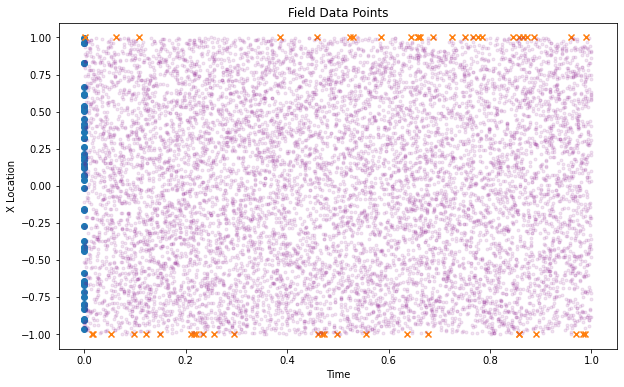

In [5]:
fig = plt.figure(figsize=(10,6))
plt.scatter(t_0, x_0, marker='o', vmin=-1, vmax=1)
plt.scatter(t_b, x_b, marker='x', vmin=-1, vmax=1)
plt.scatter(t_r, x_r, c='purple', marker='.', alpha=0.1)
plt.xlabel('Time')
plt.ylabel('X Location')
plt.title('Field Data Points')

### Function to initialize the model

In [6]:
def initialize(nhl=8, npl=20): # Hyperparameters same as that in paper giving grounds to compare
    # Initializing a feed-forward neural network
    model = tf.keras.Sequential()

    # Input ---> [t,x]
    model.add(tf.keras.Input(2))

    # Adding hidden layers
    for _ in range(nhl):
        model.add(tf.keras.layers.Dense(npl,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output ---> u_hat
    model.add(tf.keras.layers.Dense(1))
    
    return model

### Function to find derivatives of NN O/P to represent PDE

In [7]:
def i_grads(model, X_r):
    # GradientTape to evaluate derivatives
    with tf.GradientTape(persistent=True) as tape:
        # Spliting t and x to compute partial derivatives through Auto-Differentiation
        t, x = X_r[:, 0:1], X_r[:,1:2]
        # tape.watch allows to focus on variables to be computer w.r.t
        tape.watch(t)
        tape.watch(x)
        # Determine residual 
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))
        # Computing gradient u_x within the GradientTape as we need second derivative
        u_x = tape.gradient(u, x)
            
    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)
    del tape

    return loss_PDE(t, x, u, u_t, u_x, u_xx)

### Function to evaluate full loss after each epoch

In [8]:
def full_loss(model, X_r, X_data, u_data):  
    # Compute F^r
    f = i_grads(model, X_r)
    F_r = tf.reduce_mean(tf.square(f))
    
    # Initializing loss
    loss = F_r
    
    # Adding IC & BC loss
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))
    
    return loss

### House-keeping function to get derivatives of all trainable parameters to be used in back-prop

In [9]:
def get_grads_model(model, X_r, X_data, u_data):
    # Function to fetch gradients of trainable parameters used in back-propagation
    
    with tf.GradientTape(persistent=True) as tape:
        # Derivative of loss w.r.t trainable variables
        tape.watch(model.trainable_variables)
        loss = full_loss(model, X_r, X_data, u_data)

    z = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, z

### Model particulars

In [10]:
# Initializing model
model = initialize()

lr = 1e-3
# Adam optimizer is used here unlike in authors' code
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

### Defining training function and running the model

In [11]:
def PINN_training():
    # Computing current loss and gradient w.r.t. parameters
    loss, grads = get_grads_model(model, X_r, X_data, u_data)
    
    # Performing gradient descent step with Adam optimizer
    adam_optimizer.apply_gradients(zip(grads, model.trainable_variables)) # Zipping the gradients and trainable parameters
    return loss

######## MAIN TRAINING LOOP ########

N = 2500  # Number of training iterations
history = []  # Empty list to keep track of loss history

# Starting the timer
start = time()

for i in range(N+1):
    
    loss = PINN_training()
    
    # Append current loss to hist
    history.append(loss.numpy())
    
    # Printing loss after 100 epochs
    if i%100 == 0:
        print("Iteration No. {:05d} ----> Loss = {:10.6e}".format(i,loss))
        
# Printing computation time
print('\nTime Taken for Training = ',(time()-start))

Iteration No. 00000 ----> Loss = 7.341093e-01
Iteration No. 00100 ----> Loss = 1.992111e-01
Iteration No. 00200 ----> Loss = 1.400329e-01
Iteration No. 00300 ----> Loss = 1.209257e-01
Iteration No. 00400 ----> Loss = 1.012050e-01
Iteration No. 00500 ----> Loss = 9.094870e-02
Iteration No. 00600 ----> Loss = 8.452500e-02
Iteration No. 00700 ----> Loss = 7.788864e-02
Iteration No. 00800 ----> Loss = 7.168066e-02
Iteration No. 00900 ----> Loss = 6.114380e-02
Iteration No. 01000 ----> Loss = 4.243037e-02
Iteration No. 01100 ----> Loss = 2.929205e-02
Iteration No. 01200 ----> Loss = 1.918212e-02
Iteration No. 01300 ----> Loss = 1.451019e-02
Iteration No. 01400 ----> Loss = 1.252111e-02
Iteration No. 01500 ----> Loss = 8.263117e-03
Iteration No. 01600 ----> Loss = 2.096215e-02
Iteration No. 01700 ----> Loss = 5.680689e-03
Iteration No. 01800 ----> Loss = 2.003119e-02
Iteration No. 01900 ----> Loss = 4.312817e-03
Iteration No. 02000 ----> Loss = 3.787498e-03
Iteration No. 02100 ----> Loss = 3

## Plotting

Text(0, 0.5, 'Loss Value')

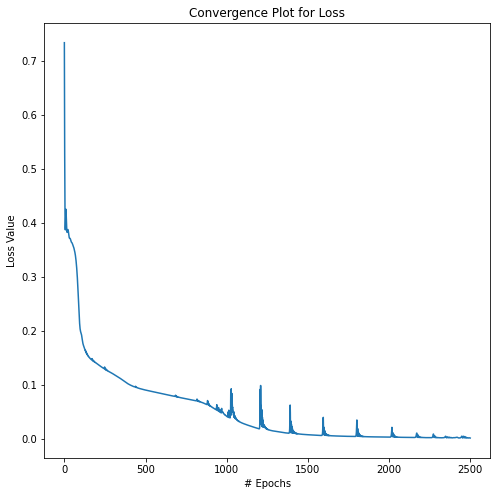

In [13]:
######## PLOT FOR LOSS HISTORY ########

plt.figure(figsize=(8,8))
plt.title("Convergence Plot for Loss")
plt.plot(history)
plt.xlabel('# Epochs')
plt.ylabel('Loss Value')

In [15]:
%matplotlib widget

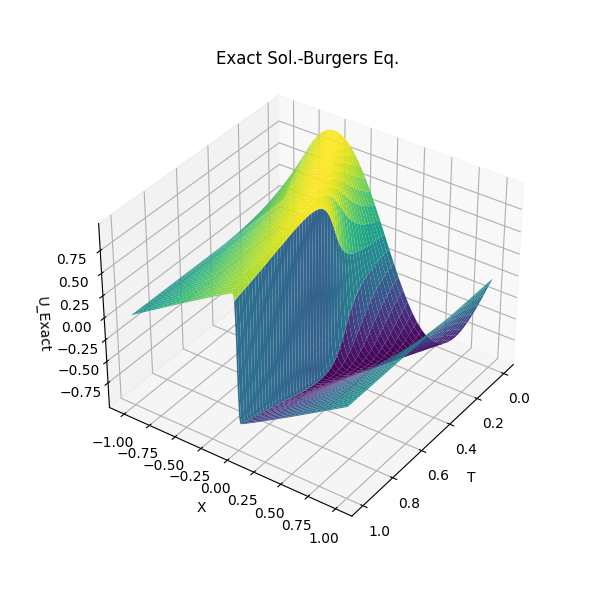

In [16]:
data = scipy.io.loadmat('burgers_shock.mat')  # Exacct solution to the given equation
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

tspace = np.linspace(lb[0], ub[0], len(t))
xspace = np.linspace(lb[1], ub[1], len(x))

T, X = np.meshgrid(tspace, xspace) # Creating a meshgrid for:
                                   # 1) Plotting
                                   # 2) Used later to transform into a tensor and deployed as test points
interactive(True)
fig = plt.figure(figsize=(6,6))
px = fig.add_subplot(111, projection='3d')
px.plot_surface(T, X, Exact.T, cmap='viridis');
px.view_init(35,35)
px.set_xlabel('T')
px.set_ylabel('X')
px.set_zlabel('U_Exact')
px.set_title('Exact Sol.-Burgers Eq.')
interactive(False)

### The exact data from the authors is defined for the same domain with 100 points for time and 256 points for space. The idea is to use the same spatio-temporal coordinates and run them through the PINN solver and evaluate the performance with L2 error as done by the authors.

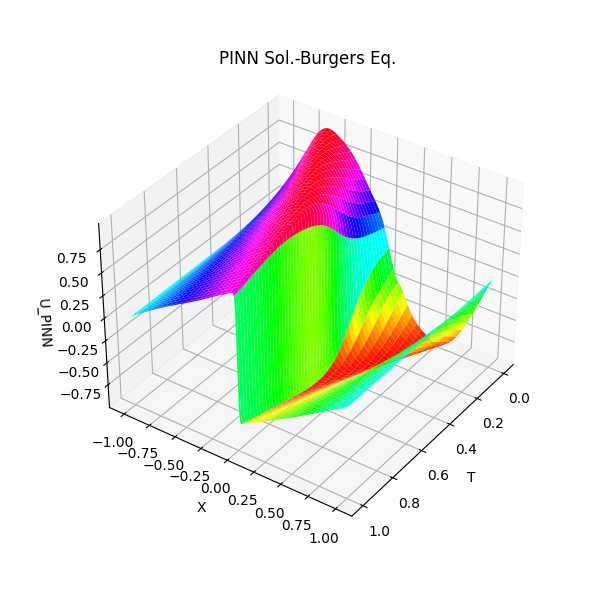

In [17]:
interactive(True)
domain = np.vstack([T.flatten(),X.flatten()]).T  # Domain of testing
u_pred = model(tf.cast(domain,dt))               # Predicted values of u
u_pred = u_pred.numpy().reshape(len(x),len(t))
fig = plt.figure(figsize=(6,6))
px = fig.add_subplot(111, projection='3d')
px.plot_surface(T, X, u_pred, cmap='hsv');
px.view_init(35,35)
px.set_xlabel('T')
px.set_ylabel('X')
px.set_zlabel('U_PINN')
px.set_title('PINN Sol.-Burgers Eq.')
interactive(False)

# ANALYSIS

### We clearly observe that both the exact solution and PINN solution are very close. Also, the PINN solution distinctly captures the fluid flow discontinuity starting from T = 0.3. PINN has successfully trained on and tested upon the field for Burgers' Equation.

# Calculating L2 Error w.r.t Exact Sol.

In [18]:
L2 = np.mean((Exact.T-u_pred)**2)

print("L2 Error of the PINN Solution w.r.t Exact Solution = ",L2)

L2 Error of the PINN Solution w.r.t Exact Solution =  0.0008804319533277738


### L2 error value for the same number of sampling points with Adam is *8.8e-4* as compared to the *6.7e-4* reported in the paper. Time of training is *518 seconds*.

### The same PC takes *949 seconds* to run the L-BFGS code used by the authors. That means although the L2 error is up by 30%, it is compensated by the fact that Adam takes only *50%* of the training time.

### Using Adam over L-BFGS reduces computational complexity dramatically as observed. Since L-BFGS is a double order method that requires storing and inverting of a Hessian matrix and only uses a linear search for evaluating direction and step-size, it gives not much freedom in choosing optimization methodologies. Adam on the other hand is a modified gradient descent method that is more comfortably fused with existing neural network architectures and also enable hyper-parameter tuning. This facet is very handy when it will come to solving more complex PDEs with PINNs.

### Also to be noted is that LHS was not used but only random sampling, thus reducing complexity even more. Multiple approaches were executed but uniform initialization for IC, internal points and 't' of BC, and Bernoulli distribution for 'x' of BC worked best. LHS was also tried but gave almost similar results.

### The current code also gives more liberty on choosing the supervised points, i.e the IC and BC points unlike the authors' code which bunched N$_{0}$ and N$_{b}$ points together and chose fixed number of points through LHS followed by random selection. Segregating these enables accentuated enforcement of physics. For example, in a system where BC is more complex than IC, a smaller number of points can be chosen for the latter. Similarly, more points for complex geometries, or regions of enhanced activity (like region near Boundary Layer in fluid or heat flow) can be included.